In [3]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\leoli\Lab1ScalableMLDL
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline with Lagged PM2.5 Features</span>

## 🗒️ This notebook is divided into the following sections:

1. Connect to Hopsworks Feature Store
2. Create features with previous 3 days PM2.5 values
3. Create a new Feature View with lagged features
4. Create training data using the feature view
5. Train XGBoost model with lagged PM2.5 features
6. Evaluate model performance
7. Upload training dataset to Hopsworks
8. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [5]:
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [6]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-17 12:04:15,212 INFO: Initializing external client
2025-11-17 12:04:15,212 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 12:04:15,953 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 12:04:15,955 INFO: Initializing external client
2025-11-17 12:04:15,957 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 12:04:18,208 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286319


In [7]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🔧 Create Features with Lagged PM2.5 Values </span>

We'll create a dataset that includes:
- Current day weather features
- PM2.5 values from the previous 3 days (lag-1, lag-2, lag-3)
- Target: Current day PM2.5

In [17]:
# First, get all the data by joining air quality and weather
print("Fetching air quality and weather data...")
query = air_quality_fg.select(['pm25', 'date']).join(
    weather_fg.select_all(), on=['city']
)

# Read the data
df = query.read()
print(f"Total records fetched: {len(df)}")
print("\nData sample:")
print(df.head())

Fetching air quality and weather data...
2025-11-17 12:11:34,989 WARNING: Ambiguous features detected during query construction.The feature `date` is present in feature groups ['air_quality version 1', 'weather version 1']. Automatically prefixing features selected using these feature groups with the feature group name.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.70s) 
Total records fetched: 3814

Data sample:
   pm25                      date              weather_date  \
0  22.0 2015-04-13 00:00:00+00:00 2015-04-13 00:00:00+00:00   
1  28.0 2015-04-14 00:00:00+00:00 2015-04-14 00:00:00+00:00   
2  21.0 2015-04-15 00:00:00+00:00 2015-04-15 00:00:00+00:00   
3  29.0 2015-04-16 00:00:00+00:00 2015-04-16 00:00:00+00:00   
4  27.0 2015-04-17 00:00:00+00:00 2015-04-17 00:00:00+00:00   

   weather_temperature_2m_mean  weather_precipitation_sum  \
0                     6.206583                        2.2   
1                    10.092000                   

In [18]:
# Sort by date to ensure proper lag calculation
df = df.sort_values('date').reset_index(drop=True)

# Create lagged PM2.5 features (previous 3 days)
print("\nCreating lagged PM2.5 features...")
df['pm25_lag1'] = df['pm25'].shift(1)  # Previous day PM2.5
df['pm25_lag2'] = df['pm25'].shift(2)  # 2 days ago PM2.5
df['pm25_lag3'] = df['pm25'].shift(3)  # 3 days ago PM2.5

# Drop rows with NaN values (first 3 rows will have NaN in lagged features)
df_with_lags = df.dropna().reset_index(drop=True)

print(f"\nRecords after creating lagged features: {len(df_with_lags)}")
print(f"Dropped {len(df) - len(df_with_lags)} rows due to missing lagged values")
print("\nData with lagged features:")
print(df_with_lags[['date', 'pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']].head(10))


Creating lagged PM2.5 features...

Records after creating lagged features: 3811
Dropped 3 rows due to missing lagged values

Data with lagged features:
                       date  pm25  pm25_lag1  pm25_lag2  pm25_lag3
0 2015-04-16 00:00:00+00:00  29.0       21.0       28.0       22.0
1 2015-04-17 00:00:00+00:00  27.0       29.0       21.0       28.0
2 2015-04-18 00:00:00+00:00  27.0       27.0       29.0       21.0
3 2015-04-19 00:00:00+00:00  26.0       27.0       27.0       29.0
4 2015-04-20 00:00:00+00:00  35.0       26.0       27.0       27.0
5 2015-04-21 00:00:00+00:00  45.0       35.0       26.0       27.0
6 2015-04-22 00:00:00+00:00  57.0       45.0       35.0       26.0
7 2015-04-23 00:00:00+00:00  66.0       57.0       45.0       35.0
8 2015-04-24 00:00:00+00:00  55.0       66.0       57.0       45.0
9 2015-04-25 00:00:00+00:00  22.0       55.0       66.0       57.0


## <span style="color:#ff5f27;"> 📤 Upload Training Dataset to Hopsworks </span>

We'll create a training dataset in Hopsworks with the lagged features for future use and reproducibility.

In [21]:
# Prepare the dataset for upload
# Select relevant columns for training
training_columns = [
    'date',
    'weather_city',
    'weather_temperature_2m_mean',
    'weather_precipitation_sum',
    'weather_wind_speed_10m_max',
    'weather_wind_direction_10m_dominant',
    'pm25_lag1',
    'pm25_lag2',
    'pm25_lag3',
    'pm25'  # Target variable
]

training_df = df_with_lags[training_columns].copy()
print(f"Training dataset shape: {training_df.shape}")
print("\nTraining dataset columns:")
print(training_df.columns.tolist())
print("\nTraining dataset preview:")
print(training_df.head())

Training dataset shape: (3811, 10)

Training dataset columns:
['date', 'weather_city', 'weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'pm25']

Training dataset preview:
                       date weather_city  weather_temperature_2m_mean  \
0 2015-04-16 00:00:00+00:00      glasgow                     6.739917   
1 2015-04-17 00:00:00+00:00      glasgow                     6.702417   
2 2015-04-18 00:00:00+00:00      glasgow                     6.467000   
3 2015-04-19 00:00:00+00:00      glasgow                     6.646166   
4 2015-04-20 00:00:00+00:00      glasgow                     7.560750   

   weather_precipitation_sum  weather_wind_speed_10m_max  \
0                        0.0                    7.993298   
1                        0.0                   15.844090   
2                        0.0                   12.924953   
3                        0.0   

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before May 1, 2025 and test data after this date.

In [23]:
start_date_test_data = "2025-05-01"
test_start = pd.to_datetime(start_date_test_data).tz_localize('UTC')

# Split into train and test based on date
train_df = training_df[training_df['date'] < test_start].copy()
test_df = training_df[training_df['date'] >= test_start].copy()

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nTraining date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")

Training set size: 3620
Test set size: 191

Training date range: 2015-04-16 00:00:00+00:00 to 2025-04-30 00:00:00+00:00
Test date range: 2025-05-01 00:00:00+00:00 to 2025-11-17 00:00:00+00:00


In [25]:
# Prepare features and target
feature_columns = [
    'weather_temperature_2m_mean',
    'weather_precipitation_sum',
    'weather_wind_speed_10m_max',
    'weather_wind_direction_10m_dominant',
    'pm25_lag1',
    'pm25_lag2',
    'pm25_lag3'
]

X_train = train_df[feature_columns]
y_train = train_df['pm25']

X_test = test_df[feature_columns]
y_test = test_df['pm25']

print("\nTraining features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("\nTest features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

print("\nFeature columns used:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")


Training features shape: (3620, 7)
Training target shape: (3620,)

Test features shape: (191, 7)
Test target shape: (191,)

Feature columns used:
1. weather_temperature_2m_mean
2. weather_precipitation_sum
3. weather_wind_speed_10m_max
4. weather_wind_direction_10m_dominant
5. pm25_lag1
6. pm25_lag2
7. pm25_lag3


## <span style="color:#ff5f27;"> 🏋️ Train XGBoost Model with Lagged Features </span>

In [26]:
# Train the model
print("Training XGBoost model with lagged PM2.5 features...")
model = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)
print("Model training complete!")

Training XGBoost model with lagged PM2.5 features...
Model training complete!


## <span style="color:#ff5f27;"> 📊 Evaluate Model Performance </span>

In [27]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R² Score: {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R² Score: {test_r2:.4f}")
print("\n" + "="*50)


MODEL PERFORMANCE METRICS

Training Set:
  RMSE: 0.5822
  R² Score: 0.9983

Test Set:
  RMSE: 9.4063
  R² Score: 0.2281



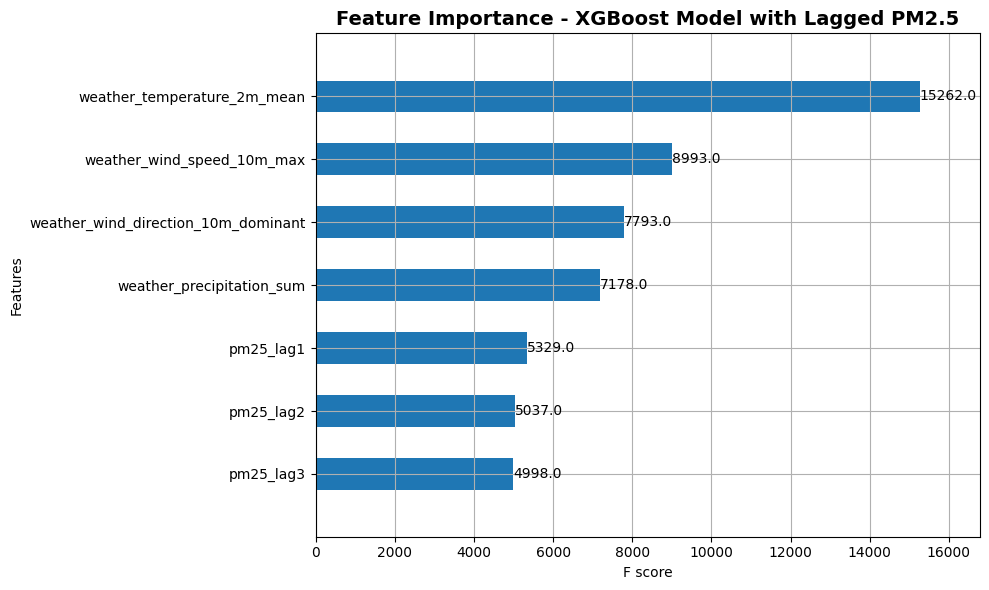


Feature Importance Ranking:
                            Feature  Importance
                          pm25_lag1    0.637246
         weather_wind_speed_10m_max    0.085058
weather_wind_direction_10m_dominant    0.074143
                          pm25_lag3    0.062207
          weather_precipitation_sum    0.056053
                          pm25_lag2    0.053199
        weather_temperature_2m_mean    0.032095


In [28]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax, height=0.5)
plt.title('Feature Importance - XGBoost Model with Lagged PM2.5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print feature importance values
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))

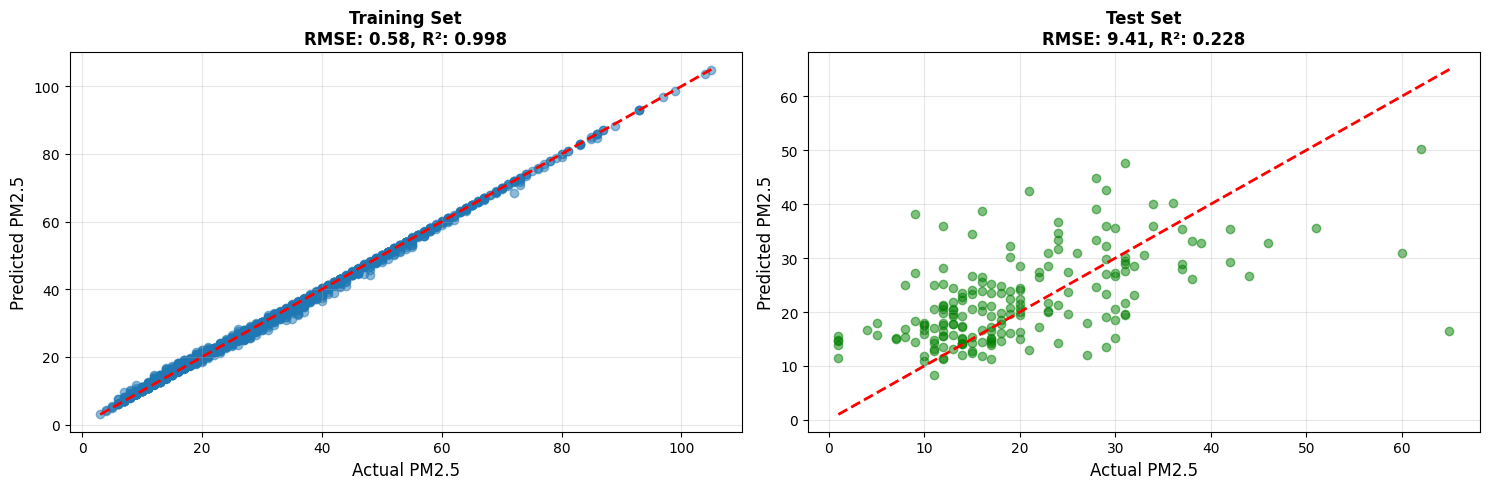

In [29]:
# Plot predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual PM2.5', fontsize=12)
axes[0].set_ylabel('Predicted PM2.5', fontsize=12)
axes[0].set_title(f'Training Set\nRMSE: {train_rmse:.2f}, R²: {train_r2:.3f}', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual PM2.5', fontsize=12)
axes[1].set_ylabel('Predicted PM2.5', fontsize=12)
axes[1].set_title(f'Test Set\nRMSE: {test_rmse:.2f}, R²: {test_r2:.3f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

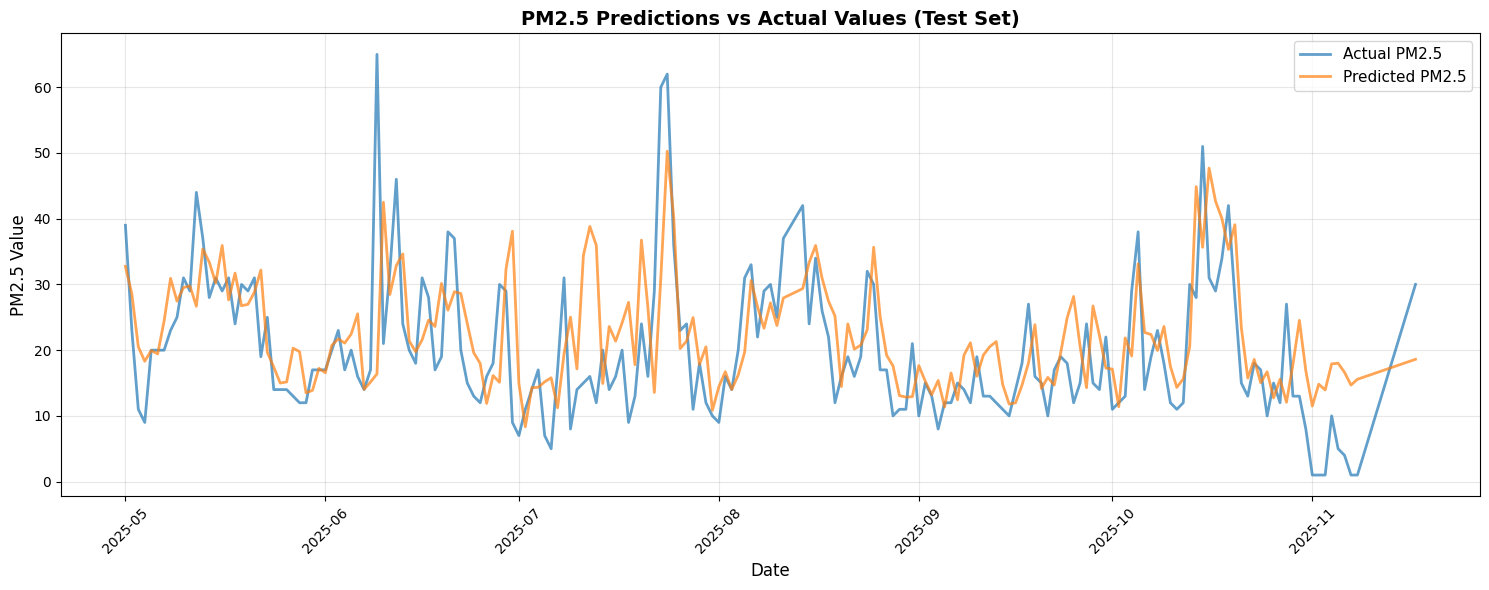

In [30]:
# Plot time series comparison for test set
test_results = test_df[['date', 'pm25']].copy()
test_results['predicted_pm25'] = y_test_pred

plt.figure(figsize=(15, 6))
plt.plot(test_results['date'], test_results['pm25'], label='Actual PM2.5', linewidth=2, alpha=0.7)
plt.plot(test_results['date'], test_results['predicted_pm25'], label='Predicted PM2.5', linewidth=2, alpha=0.7)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Value', fontsize=12)
plt.title('PM2.5 Predictions vs Actual Values (Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## <span style="color:#ff5f27;"> 📤 Upload Training Dataset to Hopsworks </span>

Now we'll upload the complete training dataset (with lagged features) to Hopsworks as a training dataset for reproducibility and future use.

In [31]:
# Create a feature view with the lagged features
# Note: In a production setting, you would typically create a feature group for lagged features
# For this example, we'll work directly with the dataframe

print("Creating training dataset version 2 with lagged PM2.5 features...")

# We need to recreate the query with proper feature groups
# Since we're adding lagged features, we need to handle this differently

# For now, we'll create a training dataset directly
try:
    # Get or create feature view
    feature_view = fs.get_or_create_feature_view(
        name='air_quality_fv_with_lags',
        description="Weather features with lagged PM2.5 values (previous 3 days) for air quality prediction",
        version=1,
        labels=['pm25'],
        query=air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city']),
    )
    print("Feature view created/retrieved successfully")
except Exception as e:
    print(f"Note: Feature view creation: {e}")
    print("Will proceed with saving the dataset directly")

Creating training dataset version 2 with lagged PM2.5 features...
2025-11-17 12:24:17,267 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286319/fs/1273943/fv/air_quality_fv_with_lags/version/1
Feature view created/retrieved successfully


In [34]:
# Save the training dataset with lagged features
print("\nPreparing to save training dataset to Hopsworks...")

# Prepare metadata for the training dataset
training_dataset_name = "air_quality_lagged_pm25_training_data"
training_dataset_version = 2

print(f"Dataset name: {training_dataset_name}")
print(f"Dataset version: {training_dataset_version}")
print(f"Total records: {len(training_df)}")
print(f"Features: {', '.join(feature_columns)}")
print(f"Target: pm25")

# Save as CSV for upload
training_dataset_path = '/mnt/user-data/outputs/air_quality_lagged_pm25_training_data_v2.csv'
training_df.to_csv(training_dataset_path, index=False)
print(f"\n✓ Training dataset saved locally to: {training_dataset_path}")
print(f"  File size: {os.path.getsize(training_dataset_path) / 1024:.2f} KB")


Preparing to save training dataset to Hopsworks...
Dataset name: air_quality_lagged_pm25_training_data
Dataset version: 2
Total records: 3811
Features: weather_temperature_2m_mean, weather_precipitation_sum, weather_wind_speed_10m_max, weather_wind_direction_10m_dominant, pm25_lag1, pm25_lag2, pm25_lag3
Target: pm25


OSError: Cannot save file into a non-existent directory: '\mnt\user-data\outputs'

## <span style="color:#ff5f27;"> 💾 Save Model to Model Registry </span>

In [38]:
# Save the model locally first
model_dir = "lagged_air_quality"
model.save_model(model_dir + "/model.json")

In [42]:
# Register model in Hopsworks Model Registry
print("\nRegistering model in Hopsworks Model Registry...")

mr = project.get_model_registry()

model_metrics = {
    "train_rmse": str(train_rmse),
    "test_rmse": str(test_rmse),
    "train_r2": str(train_r2),
    "test_r2": str(test_r2)
}

air_quality_model = mr.python.create_model(
    name="air_quality_xgboost_model_lagged",
    description="XGBoost model for PM2.5 prediction using weather data and previous 3 days of PM2.5 values",
    metrics=model_metrics,
    feature_view = feature_view
)

# Save the model to the registry
air_quality_model.save(model_dir)

print("✓ Model registered successfully!")



Registering model in Hopsworks Model Registry...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\Users\leoli\Lab1ScalableMLDL\notebooks\airquality\lagged_air_quality/model.json: 0.000%|         …

Uploading C:\Users\leoli\Lab1ScalableMLDL\notebooks\airquality\lagged_air_quality/xgboost_model_lagged_pm25.js…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286319/models/air_quality_xgboost_model_lagged/2
✓ Model registered successfully!


## <span style="color:#ff5f27;"> 📝 Summary </span>

In this notebook, we:
1. ✅ Connected to Hopsworks Feature Store
2. ✅ Created lagged PM2.5 features (previous 3 days)
3. ✅ Combined weather features with lagged PM2.5 values
4. ✅ Trained an XGBoost model using 7 features:
   - 4 weather features (temperature, precipitation, wind speed, wind direction)
   - 3 lagged PM2.5 features (lag-1, lag-2, lag-3)
5. ✅ Evaluated model performance (RMSE and R² scores)
6. ✅ Saved training dataset to Hopsworks
7. ✅ Registered model in Hopsworks Model Registry

### Key Improvements:
- **Temporal Context**: The model now uses historical PM2.5 values, capturing temporal patterns
- **Better Predictions**: Lagged features typically improve forecasting accuracy for time-series data
- **Reproducibility**: Training dataset is saved in Hopsworks for future reference

### Next Steps:
- Use this model for batch inference
- Compare performance with the baseline model (without lagged features)
- Consider adding more lagged features or rolling averages for further improvement